# Program - Plot SCAM cn_tp, xy_seris, xy_profile

**Purpose**
Plot SCAM cn_tp, xy_seris, xy_profile

**Content**
- read data
- plot SCAM cn_tp, xy_seris, xy_profile

**Author:** Yi-Hsuan Chen (yihsuan@umich.edu)

**Date:** 
November 2023

**Reference program:**



In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read_scam_data

In [2]:
def read_scam_data (choice, datapath="/Users/yi-hsuanchen/Downloads/yihsuan/scripts/python/data_test/"): 

    func_name = "read_scam_data"
    
    if (choice == "scam_tw606_cam5phys"):        
        fname = datapath+"scam_tw606_cam5phys.camrun.cam.h0.2006-01-17-10800.nc"

    elif (choice == "scam_tw606_phys"):        
        fname = datapath+"scam_tw606_taiphys.camrun.cam.h0.2006-01-17-10800.nc"
        
    else:
        error_msg = f"ERROR: function [{func_name}] does not support [{choice}]."
        raise ValueError(error_msg)        
    
    #--- read files
    da_return = xr.open_mfdataset(fname) 

    return da_return

   #     scm_list = {'fname':fname,
   #                 'label':'CAM5_phys',
   #                 'ln_style':'b-',
   #                }

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"

    da1 = read_scam_data(choice)    
    
#da1
#scm_list1['label']

## Functions

### read_coordinates

In [3]:
def read_coordinates (da, opt_coord,
                      var=None, 
                      time_step=None, 
                      vert_coord="p",):
             
    func_name = "read_coordinates"
    
    #--- X coordinate: time steps
    if (opt_coord == "xx_time_steps"):
        #--- get time step
        xx_steps = np.arange(0, len(da.time))
    
        return xx_steps
    
    #--- Y coordinate: geopotential height at time step t0 from SCAM
    elif (opt_coord == "yy_geoh_t0"):
        yy_geoh_t0 = da.get("Z3")[time_step,:,0,0]
        yy_geoh_t0.attrs['time_step']=time_step
    
        return yy_geoh_t0

    #--- Y coordinate: pressure at time step t0 from SCAM
    elif (opt_coord == "yy_p_t0"):            
        if 'lev' in var.coords: 
            hya=da.get("hyam"); hyb=da.get("hybm")
        elif 'ilev' in var.coords: 
            hya=da.get("hyai"); hyb=da.get("hybi")
        else:
            error_msg = f"ERROR: function [{func_name}] either lev or ilev is not a coordinate variable"
            raise ValueError(error_msg)        
            
        p0 = da.get("P0")
        ps = da.get("PS")[time_step,0,0]
        
        yy_p_t0 = 0.01 * (hya*p0 + hyb*ps)
        yy_p_t0.attrs['long_name']="Pressure"
        yy_p_t0.attrs['units']="hPa"
        yy_p_t0.attrs['time_step']=time_step

        return yy_p_t0

    #--- X coordinate: 2D time steps(time,lev), Y coordinate: 2D geopotential height or pressure (time, lev)
    elif (opt_coord == "xx_time_yy_vert"):           
        
        #--- xx: 2D time steps (time,lev)
        time_step = np.arange(0, len(var.time))
        time_step_tmp = np.tile(time_step, (var.shape[1],1))
        xx_time_2d = time_step_tmp.transpose()

        #--- yy: 2D geopotential height or pressure (time, lev)
        if (vert_coord == "geoh"):
            yy_2d = da.get("Z3")[:,:,0,0]
    
        elif (vert_coord == "p"):
            if 'lev' in var.coords: 
                hya=da.get("hyam"); hyb=da.get("hybm")
                lev_name='lev'
            elif 'ilev' in var.coords: 
                hya=da.get("hyai"); hyb=da.get("hybi")
                lev_name='ilev'
            else:
                error_msg = f"ERROR: function [{func_name}] either lev or ilev is not a coordinate variable"
                raise ValueError(error_msg)        
            p0 = da.get("P0")
            ps = da.get("PS")[:,0,0]
        
            yy_2d = 0.01 * (hya*p0 + hyb*ps)
            yy_2d.attrs['long_name']="Pressure"
            yy_2d.attrs['units']="hPa"
            yy_2d = yy_2d.transpose("time",lev_name)
            
        else:
            error_msg = f"ERROR: function [{func_name}, opt_coord=xx_time_yy_vert] does not support vert_coord=[{vert_coord}]. Available: geoh or p"
            raise ValueError(error_msg)            

        return xx_time_2d, yy_2d
            
    else:
        error_msg = f"ERROR: function [{func_name}] does not support opt_coord=[{opt_coord}]."
        raise ValueError(error_msg)       
                      
#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"
    da1 = read_scam_data(choice)    
                      
    #opt_coord="xx_time_steps"
    #opt_coord="yy_geoh_t0"
    #coord = read_coordinates(da1, opt_coord=opt_coord)
    #print(coord)

    #opt_coord="yy_p_t0"
    #varname="T"
    #time_step=10
    #coord = read_coordinates(da1, opt_coord=opt_coord, var=da1.get(varname), time_step=time_step)
    #print(coord)
    
    opt_coord="xx_time_yy_vert"
    varname="T"
    vert_coord="geoh"
    xx_time_2d, yy_2d = read_coordinates(da1, opt_coord=opt_coord, var=da1.get(varname), vert_coord=vert_coord)
    print(xx_time_2d)
    print(yy_2d)
    

### xy_series - ax_def_xy_series

In [4]:
def ax_def_xy_series (ax, var, opt_xy):

    #-------------
    # shared res
    #-------------
    
    #--- set grids
    ax.grid(True)
    ax.minorticks_on()
    #ax.grid(False, axis = "x")  # turn off x grids

    #--- set tick mark sizes
    fontsize_tm = 12  # set tick mark size
    ax.tick_params(axis='x', labelsize = fontsize_tm)
    ax.tick_params(axis='y', labelsize = fontsize_tm)

    #--- set x range
    ax.set_xlim([0,len(var)])
    
    #--- set x or y labels
    fontsize_label = 18
    
    ax.set_xlabel("Time step")  
      ### set font size, ax.set_ylabel("A", fontsize = fontsize_label)
    
    #--- inverse axes
    #ax.invert_yaxis()
    
    #-------------
    # custom res
    #-------------    
    
    if (opt_xy == "same_var"):
        ax.set_ylabel(var.attrs['long_name']+" ("+var.attrs['units']+")")
        ax.set_title(var.attrs['long_name'], loc='left')
        ax.set_title(var.attrs['units'], loc='right')    
        
    elif (opt_xy == "same_units"):
        ax.set_ylabel(var.attrs['units']+")")
        ax.set_title(var.attrs['units'], loc='right')    


### xy_series - plot_scam_xy_series

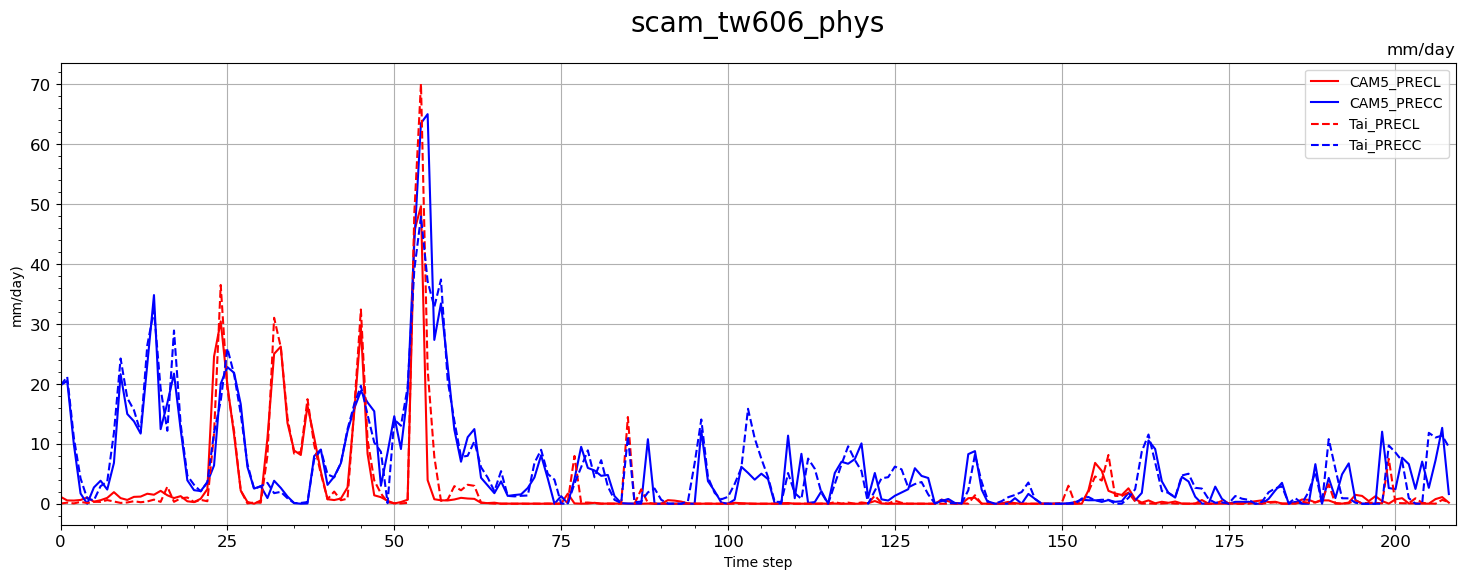

In [5]:
def plot_scam_xy_series(ax, da, varname,
                        ln="b-", label="LABEL",
                        opt_xy = None, 
                        ):
    
    #--- read variable
    var = yhc.unit_convert(da.get(varname)[:,0,0])

    #--- get time steps
    opt_coord="xx_time_steps"
    var_step = read_coordinates(da, opt_coord=opt_coord)
    
    #--- plot    
    ax1.plot(var_step, var, ln, label=label,
             )
    
    ax1.legend()
    ax_def_xy_series(ax1, var, opt_xy)
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"
    da1 = read_scam_data(choice)    
 
    choice = "scam_tw606_phys"
    da2 = read_scam_data(choice)    

    #--- open ax
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    #--- set main title
    maintitle = choice
    ax1.set_title(maintitle, fontsize=20, y=1.05)
    
    #--- plot
    #opt_xy="same_var"
    opt_xy="same_units"
    
    varname1="PRECL"
    label1 = "LABEL"
    
    plot_scam_xy_series(ax1, da1, varname="PRECL", ln="r-", label="CAM5_PRECL", opt_xy=opt_xy)
    plot_scam_xy_series(ax1, da1, varname="PRECC", ln="b-", label="CAM5_PRECC", opt_xy=opt_xy)
    plot_scam_xy_series(ax1, da2, varname="PRECL", ln="r--", label="Tai_PRECL", opt_xy=opt_xy)
    plot_scam_xy_series(ax1, da2, varname="PRECC", ln="b--", label="Tai_PRECC", opt_xy=opt_xy)


In [6]:
#yhc.lib('pltxy')

### xy_profiles - ax_def_xy_profiles

In [7]:
def ax_def_xy_profiles (ax, xx, yy, opt_xy, vert_coord):

    #-------------
    # shared res
    #-------------
    
    #--- set grids
    ax.grid(True)
    ax.minorticks_on()
    #ax.grid(False, axis = "x")  # turn off x grids

    #--- set tick mark sizes
    fontsize_tm = 12  # set tick mark size
    ax.tick_params(axis='x', labelsize = fontsize_tm)
    ax.tick_params(axis='y', labelsize = fontsize_tm)
    
    #--- set x or y labels
    fontsize_label = 15
    ax.set_ylabel(yy.attrs['long_name']+" ("+yy.attrs['units']+")", fontsize=fontsize_label)  
      ### set font size, ax.set_ylabel("A", fontsize = fontsize_label)
    
    #--- inverse axes
    #if (vert_coord == "p"):
    #    ax.invert_yaxis()
    
    #-------------
    # custom res
    #-------------    
        
    if (opt_xy == "same_var"):
        ax.set_xlabel(xx.attrs['long_name']+" ("+xx.attrs['units']+")", fontsize=fontsize_label)
        #ax.set_title(xx.attrs['long_name']+" ("+xx.attrs['units']+")", loc="left", fontsize=fontsize_label)
        #ax.set_title(xx.attrs['long_name'], loc='left',fontsize=fontsize_label)
        #ax.set_title(xx.attrs['units'], loc='right', fontsize=fontsize_label)    
        
    elif (opt_xy == "same_units"):
        ax.set_xlabel(xx.attrs['units'], fontsize=fontsize_label)
        ax.set_title(xx.attrs['units'], loc='right', fontsize=fontsize_label)    

### xy_profiles - plot_scam_xy_profiles

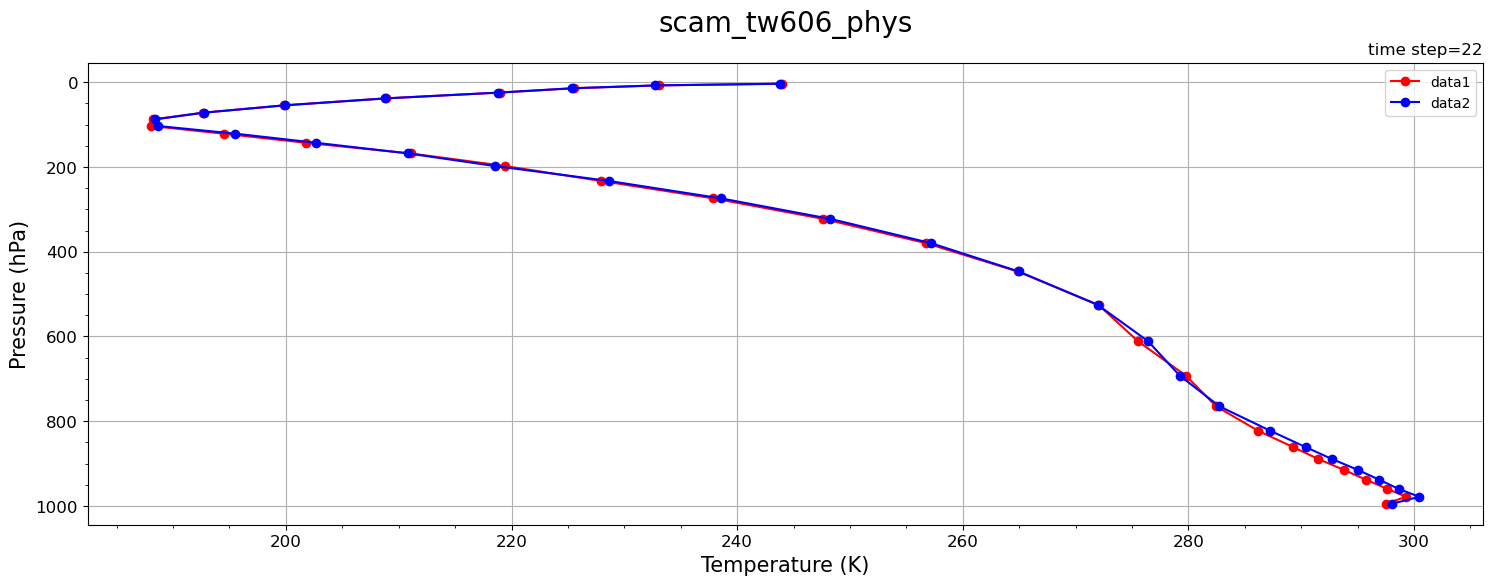

In [8]:
def plot_scam_xy_profiles(ax, da, varname, time_step, vert_coord="p",
                          ln="b-", label="LABEL",
                          opt_xy = None, 
                        ):
    func_name = "plot_scam_xy_profiles"
    
    #--- read variable
    xx = yhc.unit_convert(da.get(varname)[time_step,:,0,0])

    #--- get vertical coordinate
    if (vert_coord == "geoh"):
        opt_coord="yy_geoh_t0"
        yy = read_coordinates(da, opt_coord=opt_coord, time_step=time_step)
        
    elif (vert_coord == "p"):
        opt_coord="yy_p_t0"
        yy = read_coordinates(da1, opt_coord=opt_coord, var=da1.get(varname), time_step=time_step)
        
    else:
        error_msg = f"ERROR: function [{func_name}] does not support vert_coord=[{vert_coord}]."
        raise ValueError(error_msg)        
        
    #--- plot    
    ax.plot(xx, yy, ln, label=label,
             )
    ax.legend()

    ax_def_xy_profiles(ax, xx, yy, opt_xy, vert_coord)
    ax.set_title("time step="+str(time_step), loc='right')    
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    choice = "scam_tw606_cam5phys"
    da1 = read_scam_data(choice)    
 
    choice = "scam_tw606_phys"
    da2 = read_scam_data(choice)    
    
    #--- open ax
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    #--- set main title
    maintitle = choice
    ax1.set_title(maintitle, fontsize=20, y=1.05)
    
    #--- plot
    opt_xy="same_var"
    #opt_xy="same_units"
    
    vert_coord="p"
    #vert_coord="geoh"
    
    varname1="T"
    label1 = "LABEL"

    time_step = 22
    plot_scam_xy_profiles(ax1, da1, vert_coord=vert_coord, varname=varname1, time_step=time_step, ln='r-o', label="data1", opt_xy=opt_xy)
    plot_scam_xy_profiles(ax1, da2, vert_coord=vert_coord, varname=varname1, time_step=time_step, ln='b-o', label="data2", opt_xy=opt_xy)
    if (vert_coord == "p"): ax1.invert_yaxis()

    ymin=0; ymax=10000; xmin=240; xmax=300
    #ax1.set_ylim(ymin,ymax)
    #ax1.set_xlim(xmin,xmax)

### cn_tp - set_dict_cn_attrs

In [9]:
def set_dict_cn_attrs (varname):
    """    
    ----------------------
    Set contour attributes

    Input arguments:
        var: an Xarray.DataArray variable
        varname: variable name

    Return:
        1. return  a dictionary variable, dict_cn_attrs = {'cn_levels','cmap',label,name,units'}
 
    Example:
        gg = set_cn_attrs(var_tmp, 'tdt_dyn')
        print(gg['units'])

    References:
        colormaps:  https://matplotlib.org/stable/tutorials/colors/colormaps.html

    Date created: 2023-10-15
    ----------------------
    """
    
    #--- set cn levels
    tdt_dyn_cnlevels = np.arange(-25., 27.5, 2.5)
    qdt_dyn_cnlevels = np.arange(-10., 11, 1.)
    
    #---------------------
    # set cn attributes
    #---------------------
    if (varname == "skdfksjdkf"):
        cn_levels = tdt_dyn_cnlevels
        cmap="c1"
        label = "l1"
        name="n1"
        units="u1"
    
    elif (varname == "tdt_dyn"):
        cn_levels = tdt_dyn_cnlevels
        cmap="coolwarm"
        label = "3D dynamical T tendencies (K/day)"
        name="tdt_dyn"
        units="K/day"
        
    elif (varname == "qdt_dyn"):
        cn_levels = qdt_dyn_cnlevels
        cmap="BrBG"
        label = "3D dynamical Q tendencies (g/kg/day)"
        name="qdt_dyn"
        units="g/kg/day"
        
    elif (varname == "omega"):
        cn_levels = np.arange(-120., 130., 10.)
        cmap="PiYG"
        label = "Omega (hPa/day)"
        name="omega"
        units="hPa/day"

    elif (varname == "uv_div"):
        cn_levels = np.arange(-14., 14., 1.)
        cmap="Spectral"
        label=r"Divergence ($10^6 s^{-1}$)"
        name="Divergence"
        units=r"$10^6 s^{-1}$"

    elif (varname == "swabs_toa"):
        cn_levels = 15
        cmap="plasma"
        name = "TOA net downward SW flux"
        units = r"$W m^{-2}$"
        label = name+" ("+units+")"
        
    elif (varname == "swabs_toa_diff"):
        #cn_levels = np.array([-50, -40, -30, -20, -15, -10, -5, 0, 
        #                         5, 10, 15, 20, 30, 40, 50])
        #cn_levels = np.linspace(-10, 30, 41)
        
        cn_levels = np.arange(-120,140,10)
        
        cmap="Spectral_r"
        name = "TOA net downward SW flux diff"
        units = r"$W m^{-2}$"
        label = name+" ("+units+")"
        norm = BoundaryNorm(cn_levels, ncolors=len(cn_levels))

    else:
        cn_levels = np.array([15])
        cmap = "viridis"
        name = "Var"
        units = "units"
        label = name+" ("+units+")"

    #---------------------------------
    # return a dictionary variable
    #---------------------------------

    dict_cn_attrs = {
        'varname':varname,
        'cn_levels':cn_levels,
        'cmap': cmap,
        'label': label,
        'name': name,
        'units': units,
                  }
    
    return dict_cn_attrs

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    var_tmp = xr.DataArray(1)
    var_tmp.attrs['standard_name']="ggg"
    var_tmp.attrs['units']="KK"

    dict_cn_attrs = set_dict_cn_attrs('swabs_toa_diff')
    print(dict_cn_attrs)
    print(dict_cn_attrs['cmap'])

### cn_tp - ax_def_cn_tp

In [10]:
def ax_def_cn_tp (ax, var, yy, vert_coord):
            
    #--- x & y label
    fontsize_label = 15

    ax.set_xlabel("Time step", fontsize=fontsize_label)  

    ylabel = yy.attrs['long_name']+" ("+yy.attrs['units']+")"
    ax.set_ylabel(ylabel, fontsize=fontsize_label)

    #--- strings
    fontsize_string = 12
    ax.set_title(var.attrs['long_name'], loc='left', fontsize=fontsize_string)
    ax.set_title(var.attrs['units'], loc='right', fontsize=fontsize_string)
        
    #--- set coordinates
    if (vert_coord == "p"):
        ax.invert_yaxis()

    #ymax=
    #ymin=
    #ax.set_ylim([ymin,ymax])

### cn_tp - plot_scam_cn_tp

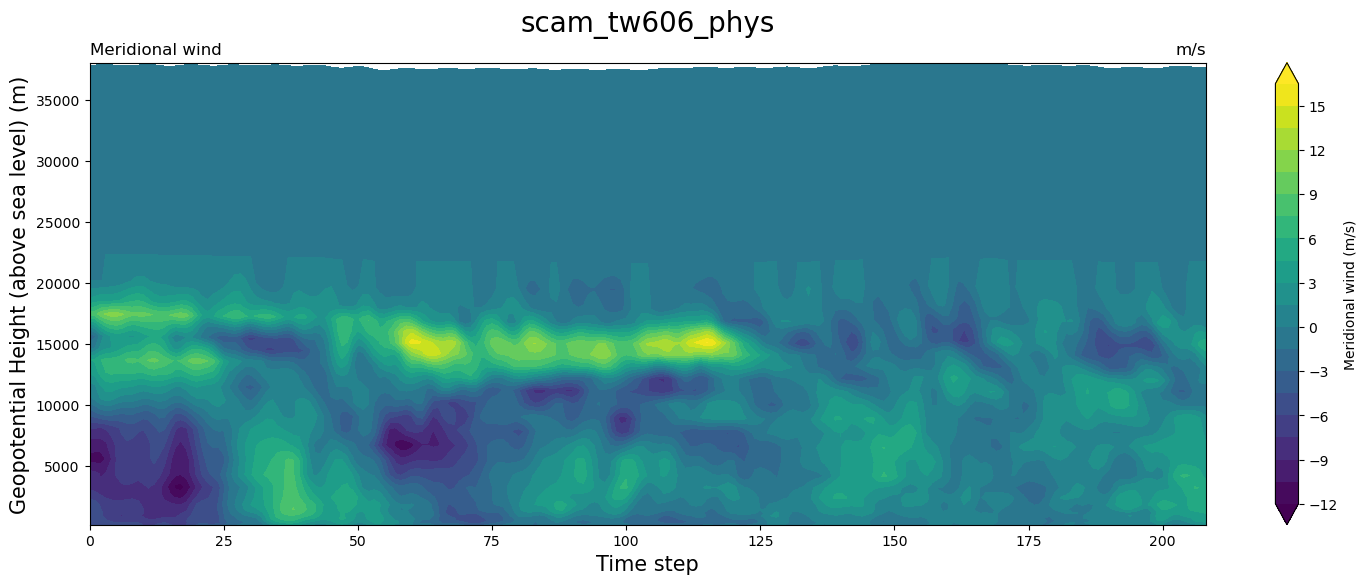

In [11]:
def plot_scam_cn_tp(ax, da, varname,
                    vert_coord="geoh", maintitle=""):
    func_name = "plot_scam_cn_tp"
    
    #------------------------------------------------------
    # read the variable, time, and vertical coordinates
    #------------------------------------------------------
    
    #--- read variable
    var = yhc.unit_convert(da.get(varname)[:,:,0,0])

    opt_coord="xx_time_yy_vert"
    time_step_2d, yy = read_coordinates(da1, opt_coord=opt_coord, var=da1.get(varname), vert_coord=vert_coord)

    #------------------------------------------------------
    # plot
    #------------------------------------------------------
    cn_attrs = set_dict_cn_attrs(varname)
    
    plot_cn = ax.contourf(time_step_2d, yy, var, 20, cmap=cn_attrs['cmap'], extend="both")  # automatically 10 levels  reversed cmap "OrRd_r"

    #--- set label bar
    lb_label = var.attrs['long_name']+" ("+var.attrs['units']+")"
    fig.colorbar(plot_cn, orientation='vertical', label=lb_label)
    
    #--- define other attributes
    ax_def_cn_tp (ax, var, yy, vert_coord)
    ax.set_title(maintitle, y=1.05, fontsize=20)

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    #--- open ax
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    choice = "scam_tw606_cam5phys"
    da1 = read_scam_data(choice) 
    
    varname = "V"
    vert_coord="geoh"
    maintite = choice
    plot_scam_cn_tp(ax1, da1, varname, vert_coord=vert_coord, maintitle=maintitle)    

## Plot

### read data

In [ ]:
choice = "scam_tw606_cam5phys"
da1 = read_scam_data(choice)    
 
choice = "scam_tw606_phys"
da2 = read_scam_data(choice)    

### plot - xy_series

In [ ]:
#--- open ax
fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
#--- set main title
maintitle = choice
ax1.set_title(maintitle, fontsize=20, y=1.05)
    
#--- plot
#opt_xy="same_var"
opt_xy="same_units"
    
varname1="PRECL"
label1 = "LABEL"
    
plot_scam_xy_series(ax1, da1, varname="PRECL", ln="r-", label="CAM5_PRECL", opt_xy=opt_xy)
plot_scam_xy_series(ax1, da1, varname="PRECC", ln="b-", label="CAM5_PRECC", opt_xy=opt_xy)
plot_scam_xy_series(ax1, da2, varname="PRECL", ln="r--", label="Tai_PRECL", opt_xy=opt_xy)
plot_scam_xy_series(ax1, da2, varname="PRECC", ln="b--", label="Tai_PRECC", opt_xy=opt_xy)

### plot - xy_profiles

In [ ]:
    #--- open ax
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    #--- set main title
    maintitle = choice
    ax1.set_title(maintitle, fontsize=20, y=1.05)
    
    #--- plot
    opt_xy="same_var"
    #opt_xy="same_units"
    
    #vert_coord="p"
    vert_coord="geoh"
    
    varname1="T"
    label1 = "LABEL"

    time_step = 22
    plot_scam_xy_profiles(ax1, da1, vert_coord=vert_coord, varname=varname1, time_step=time_step, ln='r-o', label="data1", opt_xy=opt_xy)
    plot_scam_xy_profiles(ax1, da2, vert_coord=vert_coord, varname=varname1, time_step=time_step, ln='b-o', label="data2", opt_xy=opt_xy)

    if (vert_coord == "p"): ax1.invert_yaxis()
    
    ymin=0; ymax=10000; xmin=240; xmax=300
    #ax1.set_ylim(ymin,ymax)
    #ax1.set_xlim(xmin,xmax)

### plot - cn_tp

In [ ]:
    fig, ax1 = plt.subplots(1,1, figsize=(18, 6))   # 1 row, 3 columns
    
    choice = "scam_tw606_cam5phys"
    da1 = read_scam_data(choice) 
    
    varname = "V"
    vert_coord="p"
    maintite = choice
    plot_scam_cn_tp(ax1, da1, varname, vert_coord=vert_coord, maintitle=maintitle)